In [1]:
RANDOM_SEED = 0

import random

random.seed(RANDOM_SEED)

import torch

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed_all(RANDOM_SEED)
else:
    device = "cpu"

import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

import numpy as np

np.random.seed(RANDOM_SEED)

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def plot_latent(variational_autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z, _ = variational_autoencoder.encoder(x.to(device))
        z = z.to("cpu").detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.5, cmap="tab10")
        
        if i > num_batches:
            break
    
    plt.colorbar()
    plt.gca().set_aspect("equal")


def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = variational_autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    
    plt.imshow(img, extent=[*r0, *r1])

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        
        return self.linear2(x), self.linear3(x)


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)

    def forward(self, x):
        mu, log_sigma = self.encoder(x)
        sigma = torch.exp(log_sigma)
        
        z = mu + sigma * self.N.sample(mu.shape)
        
        return self.decoder(z), mu, log_sigma
    
    
def train_variational_autoencoder(variational_autoencoder, data, epochs=10):
    optimizer = torch.optim.Adam(variational_autoencoder.parameters())
    
    for epoch in range(epochs):
        print("epoch", epoch)
        
        pbar = tqdm(data)
        for x, _ in data:
            x = x.to(device)
            
            optimizer.zero_grad()
            
            x_hat, mu, log_sigma = variational_autoencoder(x)
            sigma = torch.exp(log_sigma)
            
            recon_loss = ((x - x_hat) ** 2).sum()
            kl_loss = (sigma ** 2 + mu ** 2 - log_sigma - 1 / 2).sum()
            loss = recon_loss + kl_loss
            
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix({"recon loss": recon_loss.item(), "kl loss": kl_loss.item()})
            pbar.update()
        
        pbar.close()
        
    return variational_autoencoder

In [4]:
data = torchvision.datasets.MNIST(
    '../data',
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(
    data, 
    [train_size, test_size], 
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

shuffled_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
shuffled_train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [5]:
latent_dims = 2
variational_autoencoder = VariationalAutoencoder(latent_dims).to(device)

variational_autoencoder = train_variational_autoencoder(variational_autoencoder, shuffled_loader)

epoch 0


100%|█████████████████████████████████████████████████| 469/469 [00:12<00:00, 39.03it/s, recon loss=3.76e+3, kl loss=368]


epoch 1


100%|█████████████████████████████████████████████████| 469/469 [00:11<00:00, 39.40it/s, recon loss=3.86e+3, kl loss=399]


epoch 2


100%|█████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.99it/s, recon loss=3.74e+3, kl loss=448]


epoch 3


100%|█████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.70it/s, recon loss=3.55e+3, kl loss=457]


epoch 4


100%|█████████████████████████████████████████████████| 469/469 [00:11<00:00, 39.28it/s, recon loss=3.54e+3, kl loss=447]


epoch 5


100%|█████████████████████████████████████████████████| 469/469 [00:11<00:00, 39.19it/s, recon loss=3.58e+3, kl loss=426]


epoch 6


100%|█████████████████████████████████████████████████| 469/469 [00:11<00:00, 39.31it/s, recon loss=3.69e+3, kl loss=457]


epoch 7


100%|█████████████████████████████████████████████████| 469/469 [00:12<00:00, 39.07it/s, recon loss=3.31e+3, kl loss=461]


epoch 8


100%|██████████████████████████████████████████████████| 469/469 [00:12<00:00, 39.04it/s, recon loss=3.4e+3, kl loss=473]


epoch 9


100%|█████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.15it/s, recon loss=3.36e+3, kl loss=476]


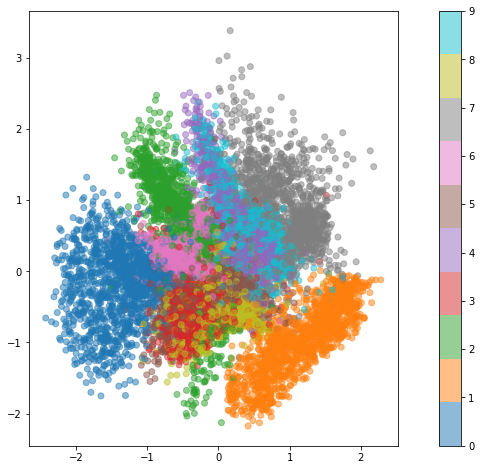

In [6]:
plt.figure(figsize=(15, 8))

plot_latent(variational_autoencoder, loader)

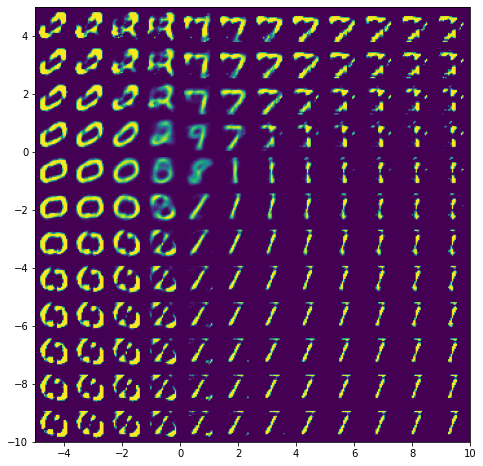

In [7]:
plt.figure(figsize=(8, 8))

plot_reconstructed(variational_autoencoder)

In [8]:
class Classifier(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.log_softmax(self.linear2(x), dim=1)
    
    
def train_classifier(classifier, data, autoencoder, epochs=10):
    optimizer = torch.optim.Adam(classifier.parameters())

    for epoch in range(epochs):
        print("epoch", epoch)
        
        pbar = tqdm(data)
        for x, y in data:
            x = x.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                z, _ = autoencoder.encoder(x)
            output = classifier(z)

            loss = F.nll_loss(output, y)

            loss.backward()
            optimizer.step()

            pbar.set_postfix({"classification loss": loss.item()})
            pbar.update()

        pbar.close()

In [9]:
classifier = Classifier(latent_dims)

train_classifier(classifier, shuffled_train_loader, variational_autoencoder)

epoch 0


100%|████████████████████████████████████████████████████████| 375/375 [00:06<00:00, 62.15it/s, classification loss=1.14]


epoch 1


100%|███████████████████████████████████████████████████████| 375/375 [00:06<00:00, 62.14it/s, classification loss=0.883]


epoch 2


100%|███████████████████████████████████████████████████████| 375/375 [00:06<00:00, 60.66it/s, classification loss=0.962]


epoch 3


100%|████████████████████████████████████████████████████████| 375/375 [00:05<00:00, 67.43it/s, classification loss=1.09]


epoch 4


100%|███████████████████████████████████████████████████████| 375/375 [00:06<00:00, 62.40it/s, classification loss=0.789]


epoch 5


100%|███████████████████████████████████████████████████████| 375/375 [00:05<00:00, 63.11it/s, classification loss=0.796]


epoch 6


100%|███████████████████████████████████████████████████████| 375/375 [00:05<00:00, 64.86it/s, classification loss=0.932]


epoch 7


100%|███████████████████████████████████████████████████████| 375/375 [00:05<00:00, 64.43it/s, classification loss=0.821]


epoch 8


100%|███████████████████████████████████████████████████████| 375/375 [00:05<00:00, 64.36it/s, classification loss=0.849]


epoch 9


100%|███████████████████████████████████████████████████████| 375/375 [00:05<00:00, 64.82it/s, classification loss=0.788]


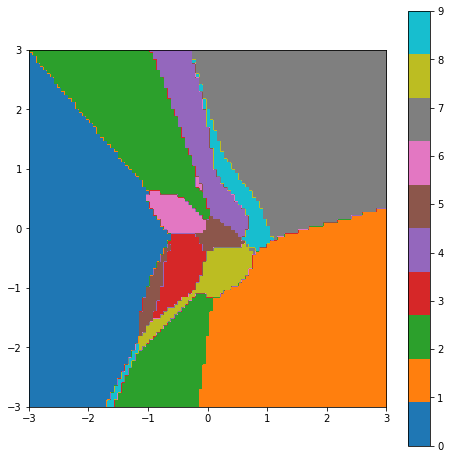

In [10]:
r0 = (-3, 3)
r1 = (-3, 3)
n = 101
w = 28
img = np.zeros((n*w, n*w))

for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]]).to(device)
        
        with torch.no_grad():
            pred = classifier(z).argmax()
        
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = pred
        
plt.figure(figsize=(8, 8))
plt.imshow(img, extent=[*r0, *r1], cmap="tab10")
plt.colorbar()
plt.gca().set_aspect("equal");

In [ ]:
num_corrects = 0
num_preds = 0

for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        z, _ = variational_autoencoder.encoder(x)
        pred = classifier(z).argmax(dim=1)
    
    num_corrects += (pred == y).sum()
    num_preds += y.shape[0]
    
(num_corrects / num_preds).item()